<h1>IBM DATA SCIENCE CAPSTONE PROJECT</h1>

<h3>What is the best place to open a cafe in Copenhagen?</h3>
<h5>Let's find out by analyzing the locations of different restaurants and cafes near the Copenhagen metro stations.</h5>

<h7>First things first, Copenhageners love coffee. There are coffee spots everywhere around the city and I bet people could not imagine their lives without such places. Now, what if someone would like to open a cafe in Copenhagen? Are there any places in the city where such a business could potentially bring profit? Let's find some places, where it could be feasible with minimum competition around. <br>
What I'm going to do is to perform the analysis which will help me better understand which parts of the city potentially lack cafes. Previously I have tried to use the districts as reference points, but I have noticed that the analysis was unclear as lots of the important parts of the city were skipped. In my opinion, using metro stations as reference points is a better idea, as metro stations are the "centers" of the city and thir nearby areas are key places when it comes to venues like restaurants or cafes.</h7>

In [159]:
#installing libraries
!pip install geopy    
!pip install folium   
!pip install geocoder

In [160]:
#importing libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import json 
from geopy.geocoders import Nominatim
import geocoder
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from folium import plugins
from folium.plugins import HeatMap
from bs4 import BeautifulSoup 

print('Libraries imported.')

Libraries imported.


In [161]:
# get coordinates of Copenhagen
copenhagen_address = 'Copenhagen, Denmark'

geolocator = Nominatim(user_agent="copenhagen_explorer")
location = geolocator.geocode(copenhagen_address)
latitude = location.latitude
longitude = location.longitude
copenhagen_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(copenhagen_address, latitude, longitude))

The geograpical coordinate of Copenhagen, Denmark are 55.6867243, 12.5700724.


In [162]:
url = "https://en.wikipedia.org/wiki/List_of_Copenhagen_Metro_stations"
source = requests.get(url)
soup = BeautifulSoup(source.text,'lxml')

metroList = []

metro_table = soup.find_all('table', {'class':'wikitable plainrowheaders sortable'})

#Append the data to the list   
for row in metro_table:
    col = row.find_all('th', {'scope':"row"})
    beautified_value = [ele.text.strip() for ele in col]
    metroList.append(beautified_value)

#There are actually two tables, first one is the metro stations that already exist and the second one is the ones that will be built by 2024
print(metroList[0])

['Aksel Møllers Have', 'Amager Strand', 'Amagerbro', 'Bella Center', 'Christianshavn#', 'DR Byen', 'Enghave Plads', 'Fasanvej', 'Femøren', 'Flintholm#', 'Forum', 'Frederiksberg#', 'Frederiksberg Allé', 'Gammel Strand', 'Islands Brygge', 'Kastrup', 'København H†#', 'Kongens Nytorv#', 'Lergravsparken', 'Lindevang', 'Lufthavnen†#', 'Marmorkirken', 'Nordhavn#', 'Nørrebro#', 'Nørrebros Runddel', 'Nørreport#', 'Nuuks Plads', 'Orientkaj†', 'Ørestad', 'Øresund', 'Østerport#', 'Poul Henningsens Plads', 'Rådhuspladsen', 'Skjolds Plads', 'Sundby', 'Trianglen', 'Vanløse†#', 'Vestamager†', 'Vibenshus Runddel']


In [183]:
#Let's get the metro stations that already exist first
df_mtr = pd.DataFrame(metroList[0])
df_mtr = df_mtr.replace({'#':''}, regex=True)
df_mtr = df_mtr.replace({'†':''}, regex=True)

df_mtr.columns = ["Metro"]

#There were some problems with coordinates for some stations as the names are simlar to some other areas etc., therefore i'm adding a 'Metro Station' at the end of each one
df_mtr['Metro'] = df_mtr['Metro'] + ' Metro Station'

print(df_mtr)

                                   Metro
0       Aksel Møllers Have Metro Station
1            Amager Strand Metro Station
2                Amagerbro Metro Station
3             Bella Center Metro Station
4           Christianshavn Metro Station
5                  DR Byen Metro Station
6            Enghave Plads Metro Station
7                 Fasanvej Metro Station
8                  Femøren Metro Station
9                Flintholm Metro Station
10                   Forum Metro Station
11           Frederiksberg Metro Station
12      Frederiksberg Allé Metro Station
13           Gammel Strand Metro Station
14          Islands Brygge Metro Station
15                 Kastrup Metro Station
16             København H Metro Station
17          Kongens Nytorv Metro Station
18          Lergravsparken Metro Station
19               Lindevang Metro Station
20              Lufthavnen Metro Station
21            Marmorkirken Metro Station
22                Nordhavn Metro Station
23              

In [211]:
#Metro Stations that will be built by 2024
df_mtr2 = pd.DataFrame(metroList[1])
df_mtr2 = df_mtr2.replace({'#':''}, regex=True)
df_mtr2 = df_mtr2.replace({'†':''}, regex=True)
df_mtr2.columns = ["Metro"]
df_mtr2['Metro'] = df_mtr2['Metro'] + ' Metro Station'
df_mtr2

,Metro
0,Enghave Brygge Metro Station
1,Havneholmen Metro Station
2,Mozarts Plads Metro Station
3,Ny Ellebjerg Metro Station
4,Sluseholmen Metro Station


In [218]:
#Let's merge them all together
df = df_mtr.append(df_mtr2, ignore_index = True)
df

,Metro,Latitude,Longitude
0,Aksel Møllers Have Metro Station,55.685676,12.532425
1,Amager Strand Metro Station,55.656220,12.631530
2,Amagerbro Metro Station,55.663540,12.602700
3,Bella Center Metro Station,55.638270,12.582750
4,Christianshavn Metro Station,55.672160,12.590960
5,DR Byen Metro Station,55.654970,12.589270
6,Enghave Plads Metro Station,55.667410,12.546090
7,Fasanvej Metro Station,55.681560,12.522830
8,Femøren Metro Station,55.645670,12.638070
9,Flintholm Metro Station,55.686580,12.499360


In [220]:
# let's get the coordinates
def get_latlng(metro):
    # set the variable to None
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(metro, copenhagen_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(metro) for metro in df["Metro"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into one dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']
df

,Metro,Latitude,Longitude
0,Aksel Møllers Have Metro Station,55.685676,12.532425
1,Amager Strand Metro Station,55.656220,12.631530
2,Amagerbro Metro Station,55.663540,12.602700
3,Bella Center Metro Station,55.638270,12.582750
4,Christianshavn Metro Station,55.672160,12.590960
5,DR Byen Metro Station,55.654970,12.589270
6,Enghave Plads Metro Station,55.667410,12.546090
7,Fasanvej Metro Station,55.681560,12.522830
8,Femøren Metro Station,55.645670,12.638070
9,Flintholm Metro Station,55.686580,12.499360


In [267]:
#There were some problems with coordinates, I have decided to manually adjust them to get better results
#I have also made up one metro station that doesn't exist, it is a very popular place in Copenhagen, so it would be a shame if I have skipped it in my analysis

#LUFTHAVN
df.at[20,'Latitude']='55.630441'
df.at[20,'Longitude']='12.649263'

#LINDEVANG
df.at[19,'Latitude']='55.683471'
df.at[19,'Longitude']='12.51312'

#OSTERPORT
df.at[30,'Latitude']='55.693217'
df.at[30,'Longitude']='12.585352'

#FORUM
df.at[10,'Latitude']='55.681821'
df.at[10,'Longitude']='12.552431'

#ORESTAD
df.at[28,'Latitude']='55.629055'
df.at[28,'Longitude']='12.579389'

#FREDRIKSBERG
df.at[11,'Latitude']='55.681223'
df.at[11,'Longitude']='12.531719'

#MADE UP ONE
df.at[44,'Metro']='Fredensbro'
df.at[44,'Latitude']='55.692449'
df.at[44,'Longitude']='12.567685'



df

,Metro,Latitude,Longitude
0,Aksel Møllers Have Metro Station,55.685676,12.532425
1,Amager Strand Metro Station,55.656220,12.631530
2,Amagerbro Metro Station,55.663540,12.602700
3,Bella Center Metro Station,55.638270,12.582750
4,Christianshavn Metro Station,55.672160,12.590960
5,DR Byen Metro Station,55.654970,12.589270
6,Enghave Plads Metro Station,55.667410,12.546090
7,Fasanvej Metro Station,55.681560,12.522830
8,Femøren Metro Station,55.645670,12.638070
9,Flintholm Metro Station,55.686580,12.499360


In [268]:
#let's display the metro stations on the map of Copenhagen

map_copenhagen= folium.Map(location=[latitude, longitude], zoom_start=11)

#let's add the markers
for lat, lng,  metro in zip(df['Latitude'], df['Longitude'], df['Metro']):
    label = '{}'.format(metro)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_copenhagen)  
    
map_copenhagen

In [277]:
CLIENT_ID = 'NYNEEVKRSS124TVDAEAVMPISNPGQ1LFMAR0DFDZ2HLTIYKSQ'
CLIENT_SECRET = 'EYBVPEYQ1FDUEDKZKG5RBODKKKDK15JOU33ZOFBBRPM5QA1V'
VERSION = '20180604'
LIMIT = 200

#I'm going to get venues in the radius of 700 meters of each station
def getDistrictVenues( latitude, longitude,metro, radius=700):
    venues = []
    for lat, long, district in zip(latitude, longitude, metro):

        #API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        #GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        for venue in results:
            venues.append((
                district,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    #convert the venues into a dataframe
    venues = pd.DataFrame(venues)
    #column names
    venues.columns = ['Metro', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

district_venues = getDistrictVenues(df['Latitude'], df['Longitude'], df['Metro'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(district_venues['VenueCategory'].unique())))
district_venues

There are 234 unique venue categories. Some of them are as below:


,Metro,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aksel Møllers Have Metro Station,55.685676,12.532425,The Coffee Collective,4fd89c20e4b04c778275e9f7,55.686960,12.533222,151,Coffee Shop
1,Aksel Møllers Have Metro Station,55.685676,12.532425,Mad & Kaffe,5b0eb642646e38002ca932b0,55.686826,12.531717,135,Café
2,Aksel Møllers Have Metro Station,55.685676,12.532425,Da Claudio,4bc0a819920eb713a340192c,55.686901,12.532269,136,Italian Restaurant
3,Aksel Møllers Have Metro Station,55.685676,12.532425,Gastronomia Candido,4be2f38f1dd22d7f604095bd,55.687325,12.530107,234,Pizza Place
4,Aksel Møllers Have Metro Station,55.685676,12.532425,Emmerys Godthåbsvej,536ba331498efec3da567aa3,55.686362,12.534116,130,Bakery
...,...,...,...,...,...,...,...,...,...
2272,Fredensbro,55.692449,12.567685,Restaurant Romarin,4caae90e8882199cd7f045d4,55.696145,12.573297,541,French Restaurant
2273,Fredensbro,55.692449,12.567685,Ronald McDonald Huset,503be133e4b0b7277cfadeaf,55.695981,12.565152,424,Hotel
2274,Fredensbro,55.692449,12.567685,Juicy,4b4758d1f964a5206f2f26e3,55.691373,12.558794,570,Sandwich Place
2275,Fredensbro,55.692449,12.567685,April Coffee,5ee9c07ee3745c0007b5129d,55.696029,12.573175,526,Coffee Shop


In [278]:
#Let's now get the venue counts
print('Top 10 distinct venue counts are as below')
district_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Café,105
Coffee Shop,72
Bakery,69
Pizza Place,65
Scandinavian Restaurant,64
Bar,42
Grocery Store,38
Sushi Restaurant,35
Gym / Fitness Center,34


In [279]:
restaurant_list =['Restaurant', 'Burger Joint','Fried Chicken Joint','Pizza Place', 'Sushi Restaurant', 'Scandinavian Restaurant', 'Italian Restaurant', 'Thai Restaurant', 'French Restaurant', 'Chinese Restaurant', 'Breakfast Spot', 'Indian Restaurant', 'Fast Food Restaurant', 'Asian Restaurant', 'Falafel Restaurant', 'Kebab Restaurant', 'Seafood Restaurant', 'Middle Eastern Restaurant', 'Taco Place', 'Vietnamese Restaurant', 'Food & Drink Shop', 'Japanese Restaurant', 'American Restaurant', 'Ramen Restaurant', 'Mexican Restaurant', 'Korean Restaurant', 'Sandwich Place', 'Food Truck', 'Greek Restaurant', 'Vegetarian / Vegan Restaurant', 'Tapas Restaurant', 'Steakhouse', 'Food Court', 'Creperie', 'Turkish Restaurant', 'South Indian Restaurant', 'Salad Place', 'African Restaurant', 'BBQ Joint', 'Bagel Shop', 'Fish & Chips Shop', 'Fried Chicken Joint', 'North Indian Restaurant', 'Meditarranean Restaurant', 'Hot Dog Joint']
cafe_list = ['Café', 'Coffee Shop']
    
district_venues['RestFlag']=False
for restCat in restaurant_list:
    district_venues['RestFlag'] = district_venues['RestFlag'] | district_venues['VenueCategory'].str.contains(restCat)
    
district_restaurants = district_venues[district_venues['RestFlag'] == True].iloc[:,:-1]
cafes = district_venues[ district_venues['VenueCategory'].isin(cafe_list) ]

print('Total number of restaurants:', len(district_restaurants['VenueId'].unique()))
print('Total number of cafes:', len(cafes['VenueId'].unique()))

Total number of restaurants: 491
Total number of cafes: 177


In [280]:
df_rest_counts = district_restaurants.groupby(['Metro']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]
df_rest_counts = df_rest_counts.sort_values(by = ['RestaurantCount'], ascending = False)

df_cafe_counts = cafes.groupby(['Metro']).count().rename(columns={"VenueCategory": "CafeCount"})[['CafeCount']]

df_cafe_counts.reset_index(inplace=True)
df_rest_counts.reset_index(inplace=True)

#let's get the cafe counts nearby each metro station
df_cafe_counts= df_cafe_counts.sort_values(by=['CafeCount'], ascending =False)
df_cafe_counts

,Metro,CafeCount
28,Nørreport Metro Station,13
12,Frederiksberg Metro Station,13
27,Nørrebros Runddel Metro Station,12
6,Enghave Plads Metro Station,12
25,Nuuks Plads Metro Station,11
24,Nordhavn Metro Station,11
11,Frederiksberg Allé Metro Station,11
10,Fredensbro,10
0,Aksel Møllers Have Metro Station,9
31,Rådhuspladsen Metro Station,9


In [281]:
#Merging the dataframes, no we're going to display the number of restaurants and cafes nearby each station
df_rest_counts = df_rest_counts.merge(df_cafe_counts).set_index('Metro')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)
df_rest_counts

,RestaurantCount,CafeCount
Metro,,
København H Metro Station,44,7
Kongens Nytorv Metro Station,40,8
Marmorkirken Metro Station,40,6
Trianglen Metro Station,34,8
Frederiksberg Allé Metro Station,31,11
Frederiksberg Metro Station,28,13
Fredensbro,27,10
Nørrebros Runddel Metro Station,26,12
Forum Metro Station,24,7


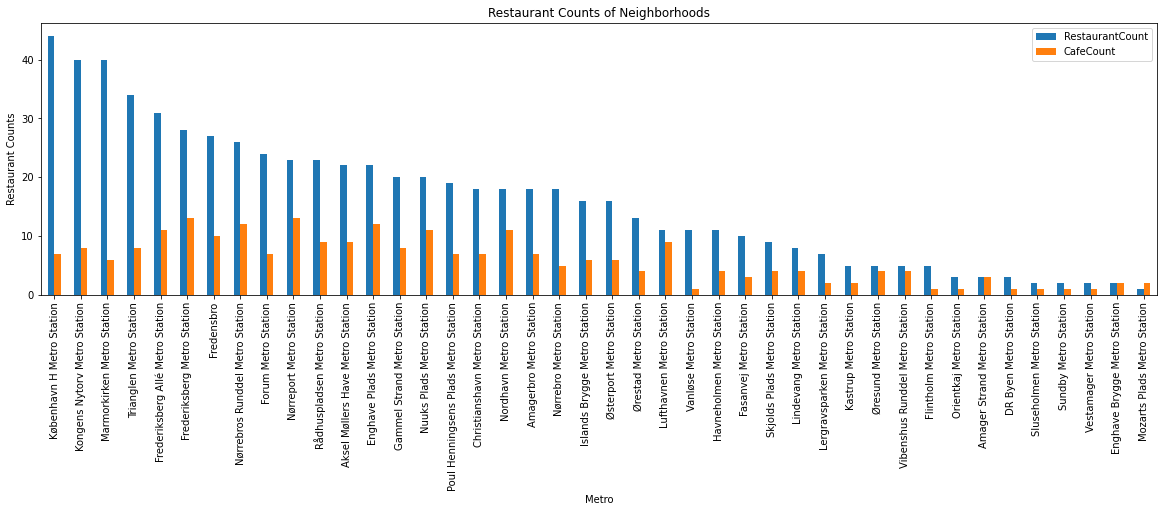

In [282]:
#Let's visualize the data and get it on the graph
df_rest_counts.plot(kind='bar',figsize=(20,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Metro')
plt.ylabel('Restaurant Counts')
plt.show()

In [283]:
#Now I'm going to get a heat map which will really help us understand the location of different restaurants and cafes
#The "heat" is created by the restaurants, the pins show the cafes

copenhagen_center = [latitude, longitude]
map_restaurant= folium.Map(location=copenhagen_center, zoom_start=12)

folium.TileLayer('cartodbpositron').add_to(map_copenhagen) 
HeatMap(district_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(copenhagen_center).add_to(map_copenhagen)
folium.Circle(copenhagen_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(copenhagen_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(copenhagen_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
for lat, lon, neig, name in zip(cafes['VenueLatitude'], cafes['VenueLongitude'], cafes['Metro'], cafes['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
           
map_restaurant

In [285]:
#one hot encoding
onehot = pd.get_dummies(district_venues[['VenueCategory']], prefix="", prefix_sep="")

#add metro column back to dataframe
onehot['Metro'] = district_venues['Metro']

venues_grouped = onehot.groupby(["Metro"]).sum().reset_index()

#move metro column to the first column and filter the venues
fixed_columns =['Metro'] + list(district_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  districts' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

45  districts' venue category are shown in 234 columns as below


,Metro,Coffee Shop,Café,Italian Restaurant,Pizza Place,Bakery,Pool,Ramen Restaurant,French Restaurant,Library,...,Fried Chicken Joint,Lawyer,Beach Bar,Bowling Alley,Buffet,Frozen Yogurt Shop,Nightclub,Diner,Ski Shop,Boutique
0,Aksel Møllers Have Metro Station,2,7,3,2,6,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
1,Amager Strand Metro Station,1,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Amagerbro Metro Station,6,1,0,3,6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bella Center Metro Station,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Christianshavn Metro Station,2,5,2,0,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,DR Byen Metro Station,0,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Enghave Brygge Metro Station,0,2,1,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
7,Enghave Plads Metro Station,5,7,2,4,4,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
8,Fasanvej Metro Station,2,1,1,2,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9,Femøren Metro Station,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [287]:
#let's get the most common venues and put it in the dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Metro','Total Number of Venues']
indicators = ['st', 'nd', 'rd']

#This will help us get the most common venues
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

        
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Metro'] = venues_grouped.iloc[ind].Metro
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head(11)

,Metro,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aksel Møllers Have Metro Station,53,Café,Bakery,Italian Restaurant,Burger Joint,Coffee Shop,Asian Restaurant,Bar,Pub,Grocery Store,Scandinavian Restaurant
1,Amager Strand Metro Station,14,Café,Beach,Coffee Shop,Burger Joint,Metro Station,Gym,Hotel,Gym / Fitness Center,Sushi Restaurant,Indian Restaurant
2,Amagerbro Metro Station,55,Coffee Shop,Bakery,Pizza Place,Discount Store,Gym / Fitness Center,Bar,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Sushi Restaurant
3,Bella Center Metro Station,20,Pizza Place,Golf Course,Breakfast Spot,American Restaurant,Ice Cream Shop,Gym,Supermarket,Hotel,Gym / Fitness Center,Discount Store
4,Christianshavn Metro Station,53,Café,Scandinavian Restaurant,Bar,Restaurant,Bakery,Coffee Shop,Park,Hotel,Steakhouse,Seafood Restaurant
5,DR Byen Metro Station,18,Concert Hall,Pizza Place,Bar,Food Truck,Park,Playground,Gym / Fitness Center,River,College Cafeteria,Café
6,Enghave Brygge Metro Station,16,Harbor / Marina,Café,Bus Station,Beach Bar,Discount Store,Grocery Store,Sushi Restaurant,Rafting,Science Museum,Beach
7,Enghave Plads Metro Station,74,Café,Coffee Shop,Park,Pizza Place,Bakery,Music Venue,Wine Bar,Cocktail Bar,Greek Restaurant,Italian Restaurant
8,Fasanvej Metro Station,29,Coffee Shop,Pizza Place,Grocery Store,Burger Joint,Bar,Multiplex,Fast Food Restaurant,Dessert Shop,Gastropub,Supermarket
9,Femøren Metro Station,14,Beach,Park,Fast Food Restaurant,Gym Pool,Gym,Ice Cream Shop,Gym / Fitness Center,Water Park,Performing Arts Venue,Playground


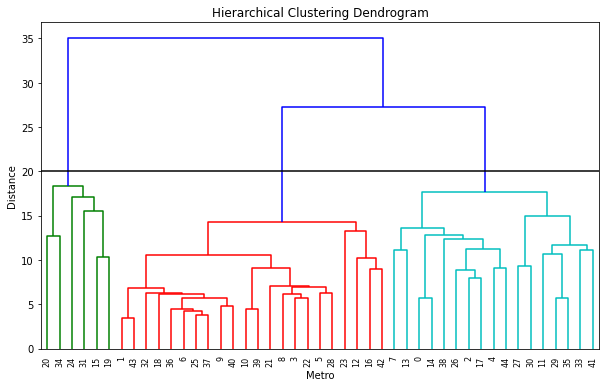

In [288]:
#I'm gonna perform a hierarchical clustering dendrogram
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Metro')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [302]:
from sklearn.cluster import AgglomerativeClustering

#Based on the dendrogram, we'll be using 3 clusters
kclusters= 3
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['MetroCluster'] = clusterresult
venues_cluster= df.merge(venues_grouped[['Metro','MetroCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Metro','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']])
venues_cluster.head(15)

,Metro,Latitude,Longitude,MetroCluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Aksel Møllers Have Metro Station,55.685676,12.532425,1,Café,Bakery,Italian Restaurant
1,Amager Strand Metro Station,55.656220,12.631530,2,Café,Beach,Coffee Shop
2,Amagerbro Metro Station,55.663540,12.602700,1,Coffee Shop,Bakery,Pizza Place
3,Bella Center Metro Station,55.638270,12.582750,2,Pizza Place,Golf Course,Breakfast Spot
4,Christianshavn Metro Station,55.672160,12.590960,1,Café,Scandinavian Restaurant,Bar
5,DR Byen Metro Station,55.654970,12.589270,2,Concert Hall,Pizza Place,Bar
6,Enghave Plads Metro Station,55.667410,12.546090,1,Café,Coffee Shop,Park
7,Fasanvej Metro Station,55.681560,12.522830,2,Coffee Shop,Pizza Place,Grocery Store
8,Femøren Metro Station,55.645670,12.638070,2,Beach,Park,Fast Food Restaurant
9,Flintholm Metro Station,55.686580,12.499360,2,Convenience Store,Grocery Store,Bakery


In [300]:
#let's make a map of clusters using folium
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#adding markers
for lat, lon, poi, cluster  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Metro'], venues_cluster['MetroCluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(copenhagen_center).add_to(map_clusters)
folium.Circle(copenhagen_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(copenhagen_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(copenhagen_center, radius=6000, fill=False, color='white').add_to(map_clusters)         
map_clusters

In [301]:
print(venues_cluster.groupby(['MetroCluster','1st Most Common Venue' ]).count()[['Metro']].rename(columns={"Metro": "Metro Count"}))

                                      Metro Count
MetroCluster 1st Most Common Venue               
0            Beer Bar                           1
             Café                               1
             Clothing Store                     1
             Hotel                              1
             Scandinavian Restaurant            2
1            Bakery                             1
             Café                               9
             Coffee Shop                        3
             Gym / Fitness Center               1
             Pizza Place                        1
             Playground                         1
             Scandinavian Restaurant            1
2            American Restaurant                1
             Beach                              1
             Café                               1
             Clothing Store                     1
             Coffee Shop                        6
             Concert Hall                       1


See the report at: https://github.com/franekl/IBM_Capstone/blob/main/IBM%20DATA%20SCIENCE%20PROFESSIONAL%20CERTIFICATE.pdf